In [1]:
%load_ext autoreload
%autoreload 2 

import numpy as np
import jax
import cProfile
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sk_PCA
from jax import numpy as jnp
from jax.random import PRNGKey, split
from hyperiax_internal_data.hyperiax.pca.pca import PhylogeneticPCA, PCA
from hyperiax_internal_data.hyperiax.pca.phylo_matrices import PhylogenicCovarianceMatrices
from hyperiax_internal_data.hyperiax.pca.gls_reconstuction import estimate_grand_mean, estimate_inner_nodes, estimate_conditional_covariance, get_confidence_interval
from hyperiax_internal_data.hyperiax.plotting import plot_tree
from hyperiax_internal_data.hyperiax.execution import OrderedExecutor
from hyperiax_internal_data.hyperiax.models import DownLambda
from hyperiax_internal_data.hyperiax.tree.topology import read_topology
from sklearn.metrics import root_mean_squared_error as RMSE
from scipy.stats import pearsonr


In [2]:
# Test phylogenetic PCA

phylo_PCA = PhylogeneticPCA()
reg_PCA = PCA()
sk_pca = sk_PCA()

# Generate random data
np.random.seed(42)
Y = np.random.randn(10, 5) 

# Use identity covariance (no phylogenetic structure)
C = np.eye(10)

# Estimate grand mean for pPCA
a = estimate_grand_mean(C, Y)

# Run pPCA
Up_ppca, Sp_ppca = phylo_PCA.fit(a, C, Y)

# Run standard PCA
U_pca, S_pca = reg_PCA.fit(Y)

# Run sklearn PCA
sk_pca.fit(Y)

# Compare eigenvalues
print("pPCA Eigenvalues:", Sp_ppca)
print("Standard PCA Eigenvalues:", S_pca)
print("Sklean PCA Eigenvalues:", sk_pca.explained_variance_)

# Compare eigenvectors (up to sign flips)
print("pPCA Eigenvectors:\n", Up_ppca)
print("Standard PCA Eigenvectors:\n", U_pca)
print("Sklean PCA Eigenvectors:\n", sk_pca.components_.T)

pPCA Eigenvalues: [1.71341075 1.22995593 0.58181577 0.44971967 0.21660019]
Standard PCA Eigenvalues: [1.71341075 1.22995593 0.58181577 0.44971967 0.21660019]
Sklean PCA Eigenvalues: [1.71341075 1.22995593 0.58181577 0.44971967 0.21660019]
pPCA Eigenvectors:
 [[-0.19140105 -0.24462942  0.908652   -0.2271501  -0.16210015]
 [ 0.64514401 -0.30162525  0.07329169  0.45332605 -0.53097574]
 [-0.30640856 -0.45450065  0.06907329  0.68266928  0.47826195]
 [-0.22650162 -0.75905736 -0.3946124  -0.39935136 -0.23943367]
 [ 0.63400762 -0.25775906  0.09214015 -0.34260688  0.63696572]]
Standard PCA Eigenvectors:
 [[-0.19140105 -0.24462942  0.908652   -0.2271501  -0.16210015]
 [ 0.64514401 -0.30162525  0.07329169  0.45332605 -0.53097574]
 [-0.30640856 -0.45450065  0.06907329  0.68266928  0.47826195]
 [-0.22650162 -0.75905736 -0.3946124  -0.39935136 -0.23943367]
 [ 0.63400762 -0.25775906  0.09214015 -0.34260688  0.63696572]]
Sklean PCA Eigenvectors:
 [[-0.19140105  0.24462942  0.908652   -0.2271501  -0.16

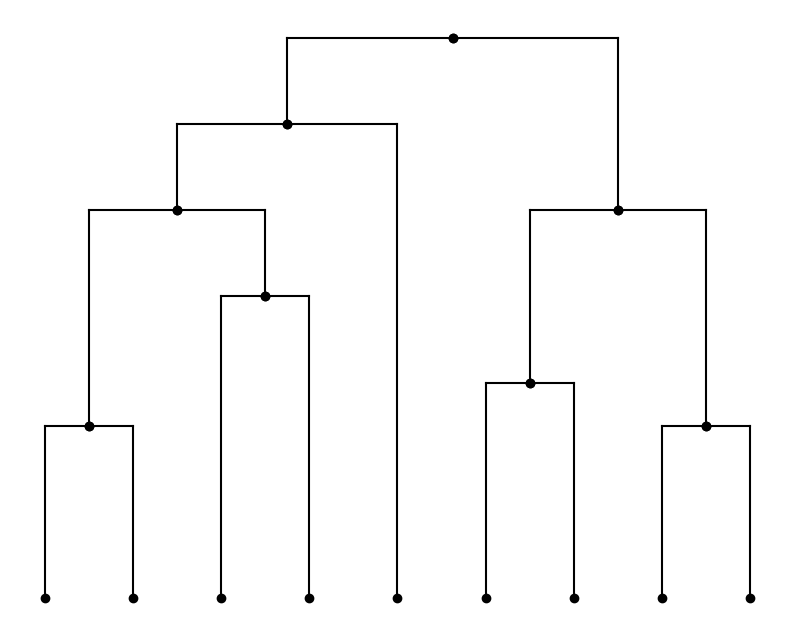

In [3]:
key = PRNGKey(0)

# Tree structure from Matins and Hansen (1997)
string_tree = "((((A:4,B:4):5,(C:7,D:7):2):2,E:11):2,((F:5,G:5):4,(H:4,I:4):5):4):1;"
tree = read_topology(string_tree)
tree.add_property('value', shape=(4,))
tree.add_property('noise', shape=(4,))

# Build HypTree with with random data (simulated via Brownian motion)
def tree_simulator(random_key): 
    random_key, subkey = split(random_key)
    tree.data['noise'] = jax.random.normal(subkey, shape=tree.data['noise'].shape)
    @jax.jit
    def down(noise, edge_length,parent_value, **args):
        return {'value': jnp.sqrt(edge_length)*noise+parent_value}
    tree.data['value'] = tree.data['value'].at[0].set(tree.data['noise'][0])
    downmodel = DownLambda(down_fn=down)
    exe = OrderedExecutor(downmodel)
    exe.down(tree)
    leaf_values = tree.data['value'][tree.is_leaf]
    inner_values = tree.data['value'][tree.is_inner]
    return tree, leaf_values, inner_values

tree, leaf_values, inner_values = tree_simulator(key)
plot_tree(tree)

In [4]:
print(inner_values)

[[-0.56997365  0.23764825  1.1220015   3.8527074 ]
 [-2.4170222   0.9092597   1.1242896   3.0500476 ]
 [-0.12729034  0.09405241  0.6878271   4.647781  ]
 [-1.7134142  -0.51718307  2.6945093   4.7778587 ]
 [-2.494147    0.21003054  2.459488    3.9244134 ]
 [ 1.41849    -0.71255285  0.98991126  2.9792495 ]
 [-2.1446593  -0.47898105  2.4540176   3.8145788 ]]


In [5]:
# Test phylogenetic covariance matrices

phylogenic_matrices = PhylogenicCovarianceMatrices(tree)

C_leaves, C_inner, C_leaves_inner = phylogenic_matrices.get_covariance_matrices()
print(C_leaves)
print(C_leaves_inner)

[[13.  0.  0.  0.  0.  2.  2.  2.  2.]
 [ 0. 13.  8.  4.  4.  0.  0.  0.  0.]
 [ 0.  8. 13.  4.  4.  0.  0.  0.  0.]
 [ 0.  4.  4. 13.  9.  0.  0.  0.  0.]
 [ 0.  4.  4.  9. 13.  0.  0.  0.  0.]
 [ 2.  0.  0.  0.  0. 13.  9.  4.  4.]
 [ 2.  0.  0.  0.  0.  9. 13.  4.  4.]
 [ 2.  0.  0.  0.  0.  4.  4. 13.  6.]
 [ 2.  0.  0.  0.  0.  4.  4.  6. 13.]]
[[2. 0. 0. 0. 0. 2. 2. 2. 2.]
 [0. 4. 4. 4. 4. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 4. 4. 4. 4.]
 [0. 8. 8. 4. 4. 0. 0. 0. 0.]
 [0. 4. 4. 9. 9. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 9. 9. 4. 4.]
 [2. 0. 0. 0. 0. 4. 4. 6. 6.]]


In [6]:
rmses = []
mean_errors = []
correlations = []
coverage = []
residuals_list = []

for i in range(100):
    #Simulate tree values 
    key = PRNGKey(i)
    tree, leaf_values, inner_values = tree_simulator(key)
    
    #Estimate root and ancestral states 
    GM = estimate_grand_mean(C_leaves, leaf_values)
    inner_estimates = estimate_inner_nodes(GM, C_leaves_inner, C_leaves, leaf_values)
    
    #Residuals 
    resids = inner_values - inner_estimates
    
    #Error 
    rmse = RMSE(inner_values, inner_estimates)
    mean_error = np.mean(resids)
    
    #Correlation between real and estimated values
    corr, _ = pearsonr(inner_values.flatten(), inner_estimates.flatten())
    
    # Confidence interval and coverage
    con_cov = estimate_conditional_covariance(C_inner, C_leaves_inner, C_leaves)
    CI = get_confidence_interval(con_cov, inner_estimates)
    lower = CI[:, 1]
    upper = CI[:, 0]
    covered = np.logical_and(inner_values >= lower, inner_values <= upper)
    coverage.append(np.mean(covered))
    
    # Collect results
    rmses.append(rmse)
    mean_errors.append(mean_error)
    correlations.append(corr)
    residuals_list.append(resids)

# Summarize
print(f"Average RMSE: {np.mean(rmses):.4f}")
print(f"Average Mean Error: {np.mean(mean_errors):.4f}")
print(f"Average Pearson r: {np.mean(correlations):.4f}")
print(f"Average 95% CI Coverage: {np.mean(coverage) * 100:.2f}%")


Average RMSE: 1.3723
Average Mean Error: -0.0040
Average Pearson r: 0.8359
Average 95% CI Coverage: 91.93%


In [7]:
filename = "/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/data/butterflies/male_dataset/species_tree.tre"
filename_csv = "/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/data/butterflies/male_dataset/landmarks.csv"
with open(filename, "r") as file:
    string_tree = file.read()
big_tree = read_topology(string_tree)

In [8]:
phylo_matrices = PhylogenicCovarianceMatrices(big_tree)
cProfile.run('phylo_matrices.get_covariance_matrices()')

         33354804 function calls (33354803 primitive calls) in 20.379 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1395630    0.183    0.000    1.069    0.000 <frozen abc>:117(__instancecheck__)
  1395630    0.178    0.000    0.483    0.000 <frozen abc>:121(__subclasscheck__)
        1    0.067    0.067   20.378   20.378 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 __init__.py:96(_xla_gc_callback)
  3102624    0.320    0.000    0.320    0.000 array.py:248(shape)
   311364    0.074    0.000    0.134    0.000 array.py:256(ndim)
  2791260    0.684    0.000    1.325    0.000 array.py:260(size)
  1396189    0.128    0.000    0.128    0.000 array.py:264(sharding)
  1395630    0.663    0.000    8.612    0.000 array.py:292(__bool__)
   311364    0.146    0.000    0.653    0.000 array.py:296(__float__)
  1396189    0.340    0.000    0.548    0.000 array.py:386(is_fully_replicated)
  1706994    0.273    0.0